In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, make_scorer, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the dataset. To connect to Kaggle API use: 
# kaggle competitions download -c titanic

scaler = preprocessing.MinMaxScaler()
# Loading and preprocessing the data
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    train_data.info()
    print('_'*40)
    test_data.info()

    titanicData = [train_data, test_data]
    for dataset in titanicData:
            
        # Removing irrelevant and mostly empty columns
        dataset.drop(['Ticket', 'Cabin', 'Name'], axis=1, inplace=True)
    
        # Replace male/female with 0/1
        dataset['Sex'].loc[(dataset['Sex'] == 'female')] = 1
        dataset['Sex'].loc[(dataset['Sex'] == 'male')] = 0

        # Replace missing two Embarked cells with the most common value
        dataset['Embarked'] = dataset['Embarked'].fillna('S')
        dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
        dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

        # Replacing null values of age with close estimations 
        guess_ages = np.zeros((2,3))
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()
                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]
        dataset['Age'] = dataset['Age'].astype(int)
        
        # Replacing SibSp and Parch with Alone column for simplyfing 
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']
        dataset['Alone'] = 0
        dataset.loc[dataset['FamilySize'] == 0, 'Alone'] = 1
        dataset.drop(['SibSp', 'FamilySize', 'Parch'], axis=1, inplace=True)


        display(dataset.head())    

    X_train = titanicData[0].drop("Survived", axis=1)
    #display(X_train.head())
    y_train = titanicData[0]["Survived"]
    X_test = titanicData[1]
    
    # Scaling the data to common range
    columns = X_train.columns
    columns1 = X_test.columns
    d = scaler.fit_transform(X_train)
    d1 = scaler.transform(X_test)
    
    scaled_X_train = pd.DataFrame(d, columns=columns)
    scaled_X_test = pd.DataFrame(d1, columns=columns1)
    display(scaled_X_train.head(15))
        
    
    # Check correlation
    for column in scaled_X_train:
        print("The correlation between {} and label is {} ".format(column, scaled_X_train[column].astype(np.float64).corr(y_train.astype(np.float64))))

    return scaled_X_train.to_numpy(), y_train.to_numpy().reshape(-1,), scaled_X_test.to_numpy()

X_train, y_train,X_test = load_data(train_path = "../input/titanic/train.csv", test_path = "../input/titanic/test.csv")    
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,  random_state=42)
#print(X_train.shape, y_train.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Alone
0,1,0,3,0,22,7.2500,0,0
1,2,1,1,1,38,71.2833,1,0
2,3,1,3,1,26,7.9250,0,1
3,4,1,1,1,35,53.1000,0,0
4,5,0,3,0,35,8.0500,0,1


,PassengerId,Pclass,Sex,Age,Fare,Embarked,Alone
0,892,3,0,34,7.8292,2,1
1,893,3,1,47,7.0000,0,0
2,894,2,0,62,9.6875,2,1
3,895,3,0,27,8.6625,0,1
4,896,3,1,22,12.2875,0,0


,PassengerId,Pclass,Sex,Age,Fare,Embarked,Alone
0,0.000000,1.0,0.0,0.2750,0.014151,0.0,0.0
1,0.001124,0.0,1.0,0.4750,0.139136,0.5,0.0
2,0.002247,1.0,1.0,0.3250,0.015469,0.0,1.0
3,0.003371,0.0,1.0,0.4375,0.103644,0.0,0.0
4,0.004494,1.0,0.0,0.4375,0.015713,0.0,1.0
5,0.005618,1.0,0.0,0.3125,0.016510,1.0,1.0
6,0.006742,0.0,0.0,0.6750,0.101229,0.0,1.0
7,0.007865,1.0,0.0,0.0250,0.041136,0.0,0.0
8,0.008989,1.0,1.0,0.3375,0.021731,0.0,0.0
9,0.010112,0.5,1.0,0.1750,0.058694,0.5,0.0


The correlation between PassengerId and label is -0.005006660767066495 
The correlation between Pclass and label is -0.33848103596101586 
The correlation between Sex and label is 0.5433513806577525 
The correlation between Age and label is -0.06029065320477122 
The correlation between Fare and label is 0.2573065223849617 
The correlation between Embarked and label is 0.10681138570892194 
The correlation between Alone and label is -0.20336708569988973 


In [3]:
logreg = LogisticRegression()
logreg.fit(X_train_0, y_train_0)
Y_pred = logreg.predict(X_val_0)
acc_log = f1_score(y_val_0, Y_pred, average="macro")
#acc_log = round(logreg.score(X_val_0, y_train) * 100, 2)
print("LogisticRegression validation accuracy is ", acc_log * 100)


# Parameters for SVC
C_candidates = [0.01, 1, 100]
gamma_candidates = [1e-04, 1e-03, 1e-02]
params = {'svc__C': C_candidates, 'svc__gamma': gamma_candidates}


# Setting up the pipeline (PCA & SVM)
pipe = Pipeline([
        ('svc',SVC())])
#pipe.fit(X_train, y_train)
cv = GridSearchCV(pipe, params, cv=5, return_train_score=True)
cv.fit(X_train_0, y_train_0)
Y_pred = cv.predict(X_val_0)
result = cross_val_score(estimator = cv, X = X_train_0, y = y_train_0, scoring = 'f1', cv = 5)
#print("The average SVC training cross value score is: ", result.sum()/len(result))
acc_log = f1_score(y_val_0, Y_pred, average="macro")
print("SVC validation accuracy is ", acc_log * 100)
#print("SVC accuracy is ", cv.best_score_ * 100)


random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_0, y_train_0)
Y_pred = random_forest.predict(X_val_0)
#acc_log = accuracy_score(y_val_0, Y_pred)
acc_log = f1_score(y_val_0, Y_pred, average="macro")
#random_forest.score(X_train_0, y_train_0)
#acc_random_forest = round(random_forest.score(X_train_0, y_train_0) * 100, 2)
#acc_random_forest
print("RandomForestClassifier validation accuracy is ", acc_log * 100)


LogisticRegression validation accuracy is  78.9906103286385
SVC validation accuracy is  77.2938689217759
RandomForestClassifier validation accuracy is  80.15779864371413


In [4]:
# Final answer
Y_pred = random_forest.predict(X_test)

x_sub = scaler.inverse_transform(X_test)

submission = pd.DataFrame({
        "PassengerId": x_sub[:,0].astype(int),
        "Survived": Y_pred
    })

display(submission.head(5))
submission.to_csv("submission.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


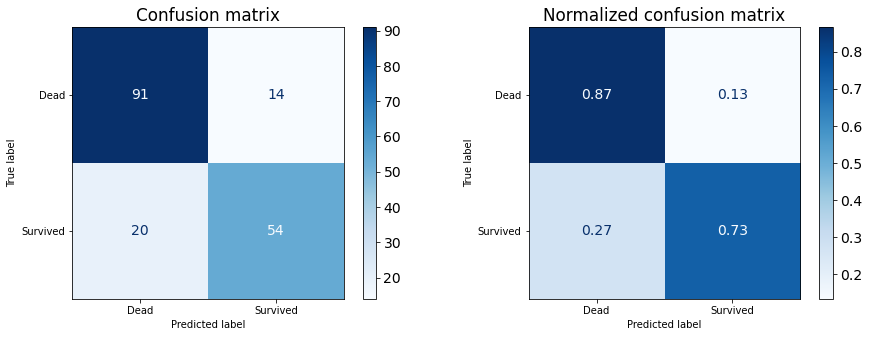

In [5]:
# Confusion matrix 

# Define class labels for confusion matrices
classes = ['Dead','Survived']

# Define plotting options (title, normalization, axes index)
options = [("Confusion matrix", None, 0),
           ("Normalized confusion matrix", 'true', 1)]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create subplots (1 row, 2 columns)
plt.rc('font', size=14)  # Set fontsize
for title, normalize, ax_idx in options:
    disp = plot_confusion_matrix(random_forest, X_val_0, y_val_0,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize, ax=axes[ax_idx])
    disp.ax_.set_title(title)

plt.show()